<a href="https://colab.research.google.com/github/Bhavani-Adula/Datasorcerers_FinalProject/blob/main/PDS_DATA_SORCERERS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CUSTOMER CHURN PREDICTION USING LLMs WITH SHAP AND BEHAVIOR SUMMARIES:**

Import libraries:

In [ ]:
import pandas as pd
import numpy as np
import random
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch

In [ ]:
# Load and Inspect Data
df = pd.read_csv("/content/drive/MyDrive/PDS_FINAL/Customer_churn.csv")
original_df = df.copy()

In [ ]:
original_df = df.copy()

In [ ]:
# Initial inspection
print("Initial shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing values:\n", df.isnull().sum())
print("\nUnique values in Churn column:", df['Churn'].unique())

Initial shape: (7043, 21)

Data Types:
 customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Missing values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract  

In [ ]:
# Data Cleaning
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())
df.drop(columns=['customerID'], inplace=True)
df['Churn'] = df['Churn'].map({'No': 'no', 'Yes': 'yes'})

EDA visualizations

In [ ]:
px.pie(df, names='Churn', title='Churn Distribution').show()
px.histogram(df, x='MonthlyCharges', color='Churn', marginal='box', nbins=50, title='Monthly Charges by Churn').show()
px.box(df, x='Contract', y='TotalCharges', color='Churn', title='Total Charges by Contract Type and Churn').show()
px.bar(df.groupby(['InternetService', 'Churn']).size().reset_index(name='count'),
       x='InternetService', y='count', color='Churn', barmode='group', title='Churn by Internet Service').show()
px.imshow(df[['tenure', 'MonthlyCharges', 'TotalCharges']].corr(), text_auto=True, title='Correlation Heatmap').show()


In [ ]:
from transformers import (
    T5Tokenizer, T5ForConditionalGeneration, Trainer, TrainingArguments,
    BertTokenizer, BertForSequenceClassification
)

In [ ]:
!pip install --upgrade transformers


 BERT-Based Classification


In [ ]:
df_bert = df.copy()
df_bert['Churn_Label'] = df_bert['Churn'].map({'no': 0, 'yes': 1})

def row_to_prompt(row):
    return (
        f"{row['gender']} customer, {'Senior' if row['SeniorCitizen'] else 'Non-senior'}, "
        f"Contract: {row['Contract']}, MonthlyCharges: ${row['MonthlyCharges']}, "
        f"InternetService: {row['InternetService']}, TechSupport: {row['TechSupport']}, "
        f"TotalCharges: ${row['TotalCharges']}"
    )

df_bert['text'] = df_bert.apply(row_to_prompt, axis=1)
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
    df_bert['text'], df_bert['Churn_Label'], test_size=0.2, stratify=df_bert['Churn_Label'], random_state=42
)

bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

class BertChurnDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = bert_tokenizer(texts.tolist(), truncation=True, padding=True, max_length=128)
        self.labels = labels.tolist()
    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }
    def __len__(self): return len(self.labels)

train_dataset_bert = BertChurnDataset(X_train_bert, y_train_bert)
val_dataset_bert = BertChurnDataset(X_val_bert, y_val_bert)

bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

bert_args = TrainingArguments(
    output_dir='./bert_results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./bert_logs',
    logging_steps=10
)

bert_trainer = Trainer(
    model=bert_model,
    args=bert_args,
    train_dataset=train_dataset_bert,
    eval_dataset=val_dataset_bert,
    tokenizer=bert_tokenizer
)

bert_trainer.train()

bert_preds_output = bert_trainer.predict(val_dataset_bert)
bert_preds = np.argmax(bert_preds_output.predictions, axis=1)

print("BERT Accuracy:", accuracy_score(y_val_bert, bert_preds))
print("\nBERT Classification Report:\n", classification_report(y_val_bert, bert_preds))

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-12-bb345fb68838>:45: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



Step,Training Loss
10,0.575500
20,0.628200
30,0.454000
40,0.412700
50,0.515400
60,0.472000
70,0.524300
80,0.470600
90,0.445100
100,0.429200


BERT Accuracy: 0.7927608232789212

BERT Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      1035
           1       0.62      0.57      0.59       374

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.73      1409
weighted avg       0.79      0.79      0.79      1409



In [ ]:
# Convert numeric predictions (0/1) to labels (no/yes)
bert_pred_labels = ['yes' if pred == 1 else 'no' for pred in bert_preds]
actual_labels = ['yes' if y == 1 else 'no' for y in y_val_bert]

# first 20 entries only
bert_results_df = pd.DataFrame({
    'Text Prompt': X_val_bert.values[:20],
    'Actual Churn': actual_labels[:20],
    'Predicted Churn': bert_pred_labels[:20]
})


print("📋 First 20 BERT Classification Results:")
display(bert_results_df)

📋 First 20 BERT Classification Results:


,Text Prompt,Actual Churn,Predicted Churn
0,"Male customer, Non-senior, Contract: Two year,...",no,no
1,"Female customer, Senior, Contract: Month-to-mo...",no,yes
2,"Female customer, Non-senior, Contract: One yea...",no,no
3,"Male customer, Non-senior, Contract: Month-to-...",no,no
4,"Female customer, Non-senior, Contract: Two yea...",no,no
5,"Female customer, Non-senior, Contract: Month-t...",no,yes
6,"Female customer, Non-senior, Contract: Month-t...",no,no
7,"Male customer, Non-senior, Contract: Month-to-...",no,no
8,"Female customer, Non-senior, Contract: Two yea...",no,no
9,"Male customer, Senior, Contract: Month-to-mont...",yes,no


In [ ]:
# -------------------- Convert to Natural Language Prompt --------------------
def row_to_text(row):
    return (
        f"A {row['gender'].lower()} customer, "
        f"{'a senior' if row['SeniorCitizen'] else 'not a senior'}, "
        f"on a {row['Contract'].lower()} contract, paying ${row['MonthlyCharges']} per month, "
        f"uses {row['InternetService'].lower()} internet, {'has' if row['TechSupport'] == 'Yes' else 'no'} tech support, "
        f"total charges ${row['TotalCharges']}. Customer support says: '{row['SupportInteraction']}' "
        f"(Sentiment: {row['Sentiment']})."
    )

df['text'] = df.apply(row_to_text, axis=1)
df['label'] = df['Churn']

In [ ]:
# -------------------- Train-Test Split --------------------
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['text'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42, stratify=df['label']
)


T5 Model Setup

In [ ]:
#Tokenizer and Model
tokenizer = T5Tokenizer.from_pretrained('t5-small')
model = T5ForConditionalGeneration.from_pretrained('t5-small')

class ChurnDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.inputs = tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")
        self.labels = tokenizer(labels, padding=True, truncation=True, max_length=10, return_tensors="pt")
    def __len__(self): return len(self.inputs['input_ids'])
    def __getitem__(self, idx):
        return {
            'input_ids': self.inputs['input_ids'][idx],
            'attention_mask': self.inputs['attention_mask'][idx],
            'labels': self.labels['input_ids'][idx]
        }

train_dataset = ChurnDataset(train_texts, train_labels, tokenizer)
val_dataset = ChurnDataset(val_texts, val_labels, tokenizer)

args = TrainingArguments(
    output_dir='./results', num_train_epochs=3,
    per_device_train_batch_size=8, per_device_eval_batch_size=8,
    logging_dir='./logs', logging_steps=10
)

trainer = Trainer(model=model, args=args, train_dataset=train_dataset, eval_dataset=val_dataset)


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
#Train Model
trainer.train()


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Step,Training Loss
10,9.169800
20,4.044100
30,2.057200
40,1.365100
50,0.837600
60,0.505400
70,0.340600
80,0.339900
90,0.409800
100,0.345900


TrainOutput(global_step=2115, training_loss=0.33088139030668473, metrics={'train_runtime': 204.8601, 'train_samples_per_second': 82.505, 'train_steps_per_second': 10.324, 'total_flos': 326154180427776.0, 'train_loss': 0.33088139030668473, 'epoch': 3.0})

In [ ]:
#Evaluate Model
# Tokenize validation texts
val_inputs = tokenizer(val_texts, return_tensors="pt", padding=True, truncation=True).to(model.device)

# Generate predictions
generated_ids = model.generate(
    input_ids=val_inputs["input_ids"],
    attention_mask=val_inputs["attention_mask"],
    max_length=10
)

# Decode predictions
preds_text = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

# Evaluate
print("Accuracy:", accuracy_score(val_labels, preds_text))
print(classification_report(val_labels, preds_text))

# Confusion Matrix
cm = confusion_matrix(val_labels, preds_text, labels=['no', 'yes'])
fig_cm = go.Figure(data=go.Heatmap(
    z=cm, x=['Predicted No', 'Predicted Yes'], y=['Actual No', 'Actual Yes'],
    colorscale='Blues', text=cm, texttemplate="%{text}"
))



Accuracy: 0.7665010645848119
              precision    recall  f1-score   support

          no       0.82      0.87      0.85      1035
         yes       0.57      0.47      0.52       374

    accuracy                           0.77      1409
   macro avg       0.70      0.67      0.68      1409
weighted avg       0.75      0.77      0.76      1409



SHAP + XGBoost

In [ ]:
# SHAP Explainability with XGBoost

import shap
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
# Prepare tabular data (exclude text columns used for T5)
df_xgb = df.copy()


In [ ]:
# Encode categorical columns
categorical_cols = df_xgb.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove("Churn")  # target column

label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_xgb[col] = le.fit_transform(df_xgb[col])
    label_encoders[col] = le

In [ ]:
# Drop only columns that exist
columns_to_drop = [col for col in ["Churn", "text", "label", "summary", "customerID", "SupportInteraction"] if col in df_xgb.columns]
X = df_xgb.drop(columns=columns_to_drop)
y = df_xgb["Churn"].map({'no': 0, 'yes': 1})

In [ ]:
# Train XGBoost model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[21:34:10] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Apply SHAP
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)


<ipython-input-21-bfb4470704e2>:2: FutureWarning:

The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.



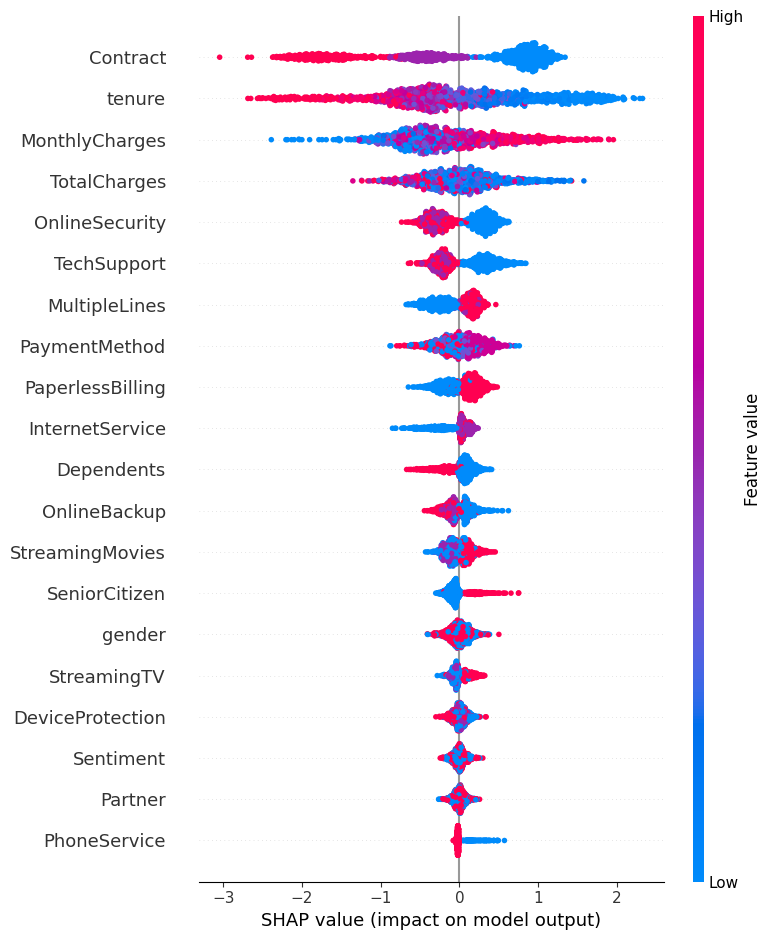

In [ ]:
# Global feature importance
shap.summary_plot(shap_values, X_test)

In [ ]:
import os
import random

In [ ]:
#Simulated Support Interaction Phrases
support_phrases = [
    "Internet keeps disconnecting. Not happy.",
    "Billing was incorrect last month.",
    "Great service, very satisfied.",
    "Slow speeds during evenings.",
    "Excellent customer support. No complaints.",
    "I want to cancel if the issue persists.",
    "Everything works fine. Happy so far.",
    "Repeated problems with my modem.",
    "Quick resolution to my last issue.",
    "No issues. Just checking my bill."
]
df["SupportInteraction"] = [random.choice(support_phrases) for _ in range(len(df))]



def analyze_sentiment(text):
    text = text.lower()
    if any(word in text for word in ["not happy", "cancel", "problems", "slow", "incorrect"]):
        return "Negative"
    elif any(word in text for word in ["great", "excellent", "happy", "fine", "no issues", "quick resolution"]):
        return "Positive"
    else:
        return "Neutral"

df["Sentiment"] = df["SupportInteraction"].apply(analyze_sentiment)


In [ ]:
# Show 10 sample rows with support interaction and sentiment
print(" Sample Support Interactions and Sentiments:\n")
display(df[['customerID', 'SupportInteraction', 'Sentiment']].head(10))


🔍 Sample Support Interactions and Sentiments:



,customerID,SupportInteraction,Sentiment
0,7590-VHVEG,Quick resolution to my last issue.,Positive
1,5575-GNVDE,I want to cancel if the issue persists.,Negative
2,3668-QPYBK,Excellent customer support. No complaints.,Positive
3,7795-CFOCW,Repeated problems with my modem.,Negative
4,9237-HQITU,Everything works fine. Happy so far.,Positive
5,9305-CDSKC,Quick resolution to my last issue.,Positive
6,1452-KIOVK,Excellent customer support. No complaints.,Positive
7,6713-OKOMC,Slow speeds during evenings.,Negative
8,7892-POOKP,Internet keeps disconnecting. Not happy.,Negative
9,6388-TABGU,No issues. Just checking my bill.,Positive


In [ ]:
# Count how many are Positive, Negative, Neutral
print("Sentiment Distribution:\n")
print(df['Sentiment'].value_counts())


Sentiment Distribution:

Sentiment
Negative    3539
Positive    3504
Name: count, dtype: int64


In [ ]:
df['customerID'] = original_df['customerID']

def generate_summary(row):
    sentiment = row['Sentiment']
    actual = row['Churn']

    if sentiment == "Negative":
        risk = "HIGH"
    elif sentiment == "Neutral":
        risk = "MODERATE"
    else:
        risk = "LOW"

    return (
        f"Customer ID: {row['customerID']}. A {row['gender'].lower()} customer, "
        f"{'senior' if row['SeniorCitizen'] else 'non-senior'}, uses {row['InternetService'].lower()} internet "
        f"with {row['Contract'].lower()} contract. Pays ${row['MonthlyCharges']} monthly, "
        f"total charges ${row['TotalCharges']}. Sentiment from support: {sentiment}. "
        f"Risk of churn (based on sentiment): {risk}. Actual churn: {actual.upper()}."
    )

In [ ]:
df['summary'] = df.apply(generate_summary, axis=1)


In [ ]:
# Step 1: Make sure customerID is in the main DataFrame
df['customerID'] = original_df['customerID']

# Step 2: Apply the summary generation function to every row
df['summary'] = df.apply(generate_summary, axis=1)

# Step 3: Display a few example summaries
print(" Sample Customer Summaries:\n")
for summary in df['summary'].head(5):
    print(summary)
    print("-" * 100)


📋 Sample Customer Summaries:

Customer ID: 7590-VHVEG. A female customer, non-senior, uses dsl internet with month-to-month contract. Pays $29.85 monthly, total charges $29.85. Sentiment from support: Positive. Risk of churn (based on sentiment): LOW. Actual churn: NO.
----------------------------------------------------------------------------------------------------
Customer ID: 5575-GNVDE. A male customer, non-senior, uses dsl internet with one year contract. Pays $56.95 monthly, total charges $1889.5. Sentiment from support: Negative. Risk of churn (based on sentiment): HIGH. Actual churn: NO.
----------------------------------------------------------------------------------------------------
Customer ID: 3668-QPYBK. A male customer, non-senior, uses dsl internet with month-to-month contract. Pays $53.85 monthly, total charges $108.15. Sentiment from support: Positive. Risk of churn (based on sentiment): LOW. Actual churn: YES.
------------------------------------------------------

In [ ]:
df[['customerID', 'summary']].to_csv("customer_summaries_with_sentiment.csv", index=False)
print(" Summaries saved to 'customer_summaries_with_sentiment.csv'")


 Summaries saved to 'customer_summaries_with_sentiment.csv'


In [ ]:
df[['customerID', 'summary']].to_csv("/content/customer_summaries_with_sentiment.csv", index=False)


In [ ]:
from google.colab import files
files.download("/content/customer_summaries_with_sentiment.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>